# Exercise : HAR_LSTM HYPERPARATEMER TUNING
## Step by step Process 
- Lets start as we know This dataset is collected from 30 persons(referred as subjects in this dataset), performing different activities with a smartphone to their waists. The data is recorded with the help of sensors (accelerometer and Gyroscope) in that smartphone. This experiment was video recorded to label the data manually.
- So after performing lots of EDA and visulization on dataset we have performed both Classical ML models and Deep learning RNN models and we know we haved two types of data:  
    1. Expert Engg features - perform Classical ML models  
    2. Raw time series data - perform Deep learning RNN models 
- After doing all above in this in this we will performs some hyperparameter tuning on our deep learning models.
- Lets Start working :

In [19]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

### Data

In [3]:
# Data directory
DATADIR = 'UCI_HAR_Dataset'

In [4]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [5]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [6]:

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).as_matrix()

In [7]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [40]:
# utility function
def plt_dynamic(x, vy, ty):
    plt.figure(figsize=(10,5))
    plt.plot(x, vy, 'b', label="Validation Loss")
    plt.plot(x, ty, 'r', label="Train Loss")
    plt.xlabel('Epochs') 
    plt.ylabel('Crossentropy Loss')
    plt.title('Crossentropy Loss VS Epochs')
    plt.legend()
    plt.grid()
    plt.show()

In [8]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)

C:\Users\nisha\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [9]:
# Configuring a session
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [10]:
# Import Keras
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


In [11]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

In [12]:
# Initializing parameters
epochs = 30
batch_size = 16
n_hidden = 32

In [13]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [14]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

C:\Users\nisha\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


In [15]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


- Defining the Architecture of LSTM

## 1. Model having 1 LSTM layer with 32 LSTM Units

In [16]:
# Initiliazing the sequential model
model1 = Sequential()
# Configuring the parameters
model1.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model1.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model1.add(Dense(n_classes, activation='sigmoid'))
model1.summary()

# Compiling the model
model1.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

# Training the model
history1 = model1.fit(X_train, Y_train, batch_size=batch_size,validation_data=(X_test, Y_test),epochs=epochs)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 39s 5ms/step - loss: 1.3139 - acc: 0.4358 - val_loss: 1.1352 - val_acc: 0.4700
Epoch 2/30
7352/7352 [==============================] - 41s 6ms/step - loss: 0.9788 - acc: 0.5773 - val_loss: 0.9513 - val_acc: 0.5884
Epoch 3/30
7352/7352 [==============================] - 41s 6ms/step - loss: 0.7977 - 

Test Score: 0.488270
Test Accuracy: 88.293180%


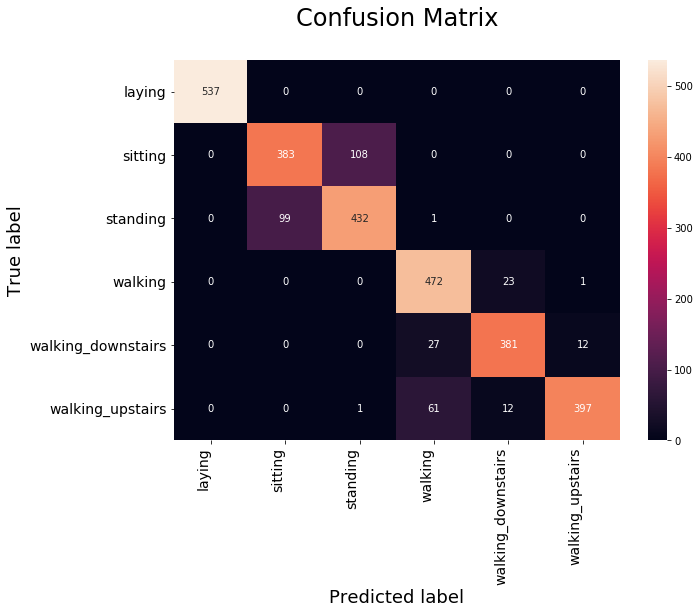

In [20]:
# Final evaluation of the model
scores = model1.evaluate(X_test, Y_test, verbose=0)
print("Test Score: %f" % (scores[0]))
print("Test Accuracy: %f%%" % (scores[1]*100))

# Confusion Matrix
Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_test, axis=1)])
Y_predictions = pd.Series([ACTIVITIES[y] for y in np.argmax(model1.predict(X_test), axis=1)])

# Code for drawing seaborn heatmaps
class_names = ['laying','sitting','standing','walking','walking_downstairs','walking_upstairs']
df_heatmap = pd.DataFrame(confusion_matrix(Y_true, Y_predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predicted label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

Accuracy: 88.29%


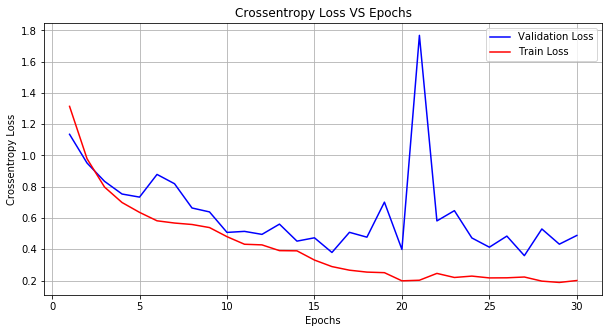

In [41]:
# Final evaluation of the model
scores = model1.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

# Test and train accuracy of the model
model_1_test = scores[1]
model_1_train = max(history1.history['acc'])

# Plotting Train and Test Loss VS no. of epochs
# list of epoch numbers
x = list(range(1,31))

# Validation loss
vy = history1.history['val_loss']
# Training loss
ty = history1.history['loss']

# Calling the function to draw the plot
plt_dynamic(x, vy, ty)

## 2. Model having 1 LSTM layer with 42 LSTM Units 

In [24]:
# Initiliazing the sequential model
model2 = Sequential()
# Configuring the parameters
model2.add(LSTM(42, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model2.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model2.add(Dense(n_classes, activation='sigmoid'))
print(model2.summary())

# Compiling the model
model2.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

# Training the model
history2 = model2.fit(X_train,Y_train,batch_size=batch_size,validation_data=(X_test, Y_test),epochs=epochs)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 42)                8736      
_________________________________________________________________
dropout_2 (Dropout)          (None, 42)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 258       
Total params: 8,994
Trainable params: 8,994
Non-trainable params: 0
_________________________________________________________________
None
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 47s 6ms/step - loss: 1.2947 - acc: 0.4499 - val_loss: 1.1957 - val_acc: 0.4571
Epoch 2/30
7352/7352 [==============================] - 43s 6ms/step - loss: 1.0003 - acc: 0.5594 - val_loss: 0.8970 - val_acc: 0.6196
Epoch 3/30
7352/7352 [==============================] - 41s 6ms/step - loss: 0.76

Test Score: 0.427173
Test Accuracy: 91.584662%


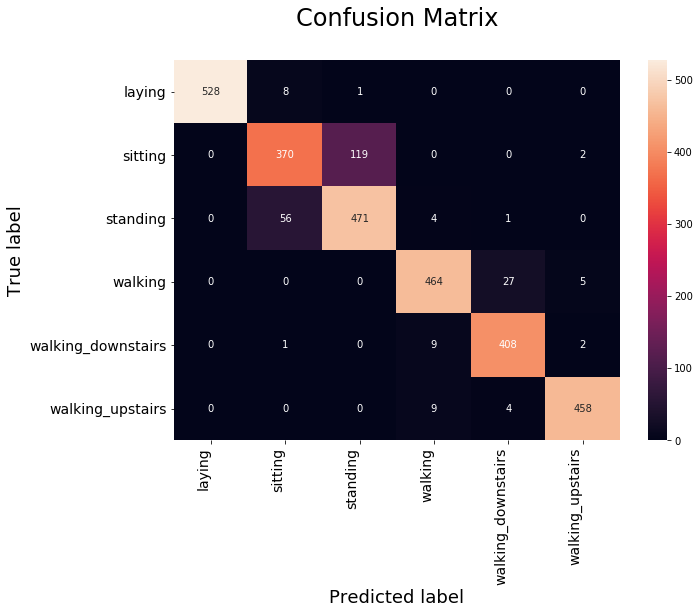

In [25]:
# Final evaluation of the model
scores2 = model2.evaluate(X_test, Y_test, verbose=0)
print("Test Score: %f" % (scores2[0]))
print("Test Accuracy: %f%%" % (scores2[1]*100))

# Confusion Matrix
Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_test, axis=1)])
Y_predictions = pd.Series([ACTIVITIES[y] for y in np.argmax(model2.predict(X_test), axis=1)])

# Code for drawing seaborn heatmaps
class_names = ['laying','sitting','standing','walking','walking_downstairs','walking_upstairs']
df_heatmap = pd.DataFrame(confusion_matrix(Y_true, Y_predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predicted label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

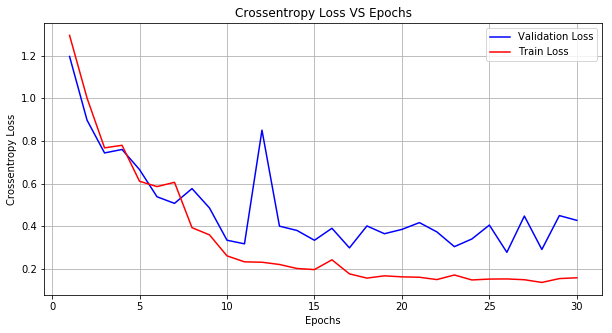

In [42]:
# Test and train accuracy of the model
model_2_test = scores2[1]
model_2_train = max(history2.history['acc'])

# Plotting Train and Test Loss VS no. of epochs
# list of epoch numbers
x = list(range(1,31))

# Validation loss
vy = history2.history['val_loss']
# Training loss
ty = history2.history['loss']

# Calling the function to draw the plot
plt_dynamic(x, vy, ty)

## 3. Model having 1 LSTM layer with 64 LSTM Units with larger Dropout

In [27]:
# Initiliazing the sequential model
model3 = Sequential()
# Configuring the parameters
model3.add(LSTM(64, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model3.add(Dropout(0.7))
# Adding a dense output layer with sigmoid activation
model3.add(Dense(n_classes, activation='sigmoid'))
print(model3.summary())

# Compiling the model
model3.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

# Training the model
history3 = model3.fit(X_train,Y_train,batch_size=batch_size,validation_data=(X_test, Y_test),epochs=epochs)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 64)                18944     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 390       
Total params: 19,334
Trainable params: 19,334
Non-trainable params: 0
_________________________________________________________________
None
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 49s 7ms/step - loss: 1.3289 - acc: 0.4153 - val_loss: 1.1952 - val_acc: 0.4842
Epoch 2/30
7352/7352 [==============================] - 46s 6ms/step - loss: 1.0808 - acc: 0.5403 - val_loss: 0.9875 - val_acc: 0.5840loss: 1.0830 - acc
Epoch 3/30
7352/7352 [==============================] - 46s 6

Test Score: 0.279943
Test Accuracy: 91.482864%


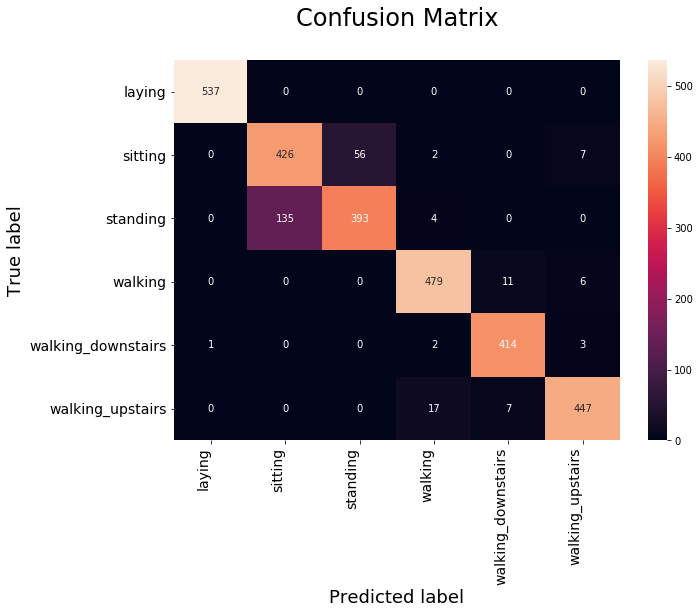

In [28]:
# Final evaluation of the model
scores3 = model3.evaluate(X_test, Y_test, verbose=0)
print("Test Score: %f" % (scores3[0]))
print("Test Accuracy: %f%%" % (scores3[1]*100))

# Confusion Matrix
Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_test, axis=1)])
Y_predictions = pd.Series([ACTIVITIES[y] for y in np.argmax(model3.predict(X_test), axis=1)])

# Code for drawing seaborn heatmaps
class_names = ['laying','sitting','standing','walking','walking_downstairs','walking_upstairs']
df_heatmap = pd.DataFrame(confusion_matrix(Y_true, Y_predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predicted label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

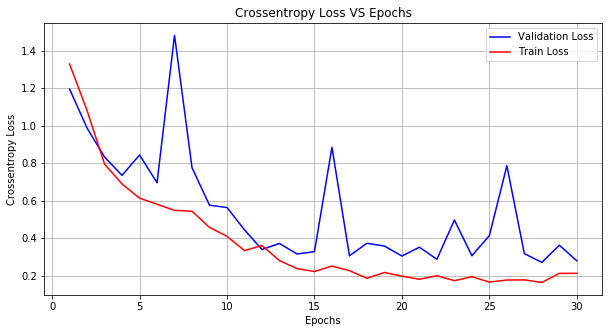

In [43]:
# Test and train accuracy of the model
model_3_test = scores3[1]
model_3_train = max(history3.history['acc'])

# Plotting Train and Test Loss VS no. of epochs
# list of epoch numbers
x = list(range(1,31))

# Validation loss
vy = history3.history['val_loss']
# Training loss
ty = history3.history['loss']

# Calling the function to draw the plot
plt_dynamic(x, vy, ty)

## 4. Model having 2 LSTM layer with 32 LSTM Units 

In [30]:
# Initiliazing the sequential model
model4 = Sequential()
# Configuring the parameters
model4.add(LSTM(32,return_sequences=True, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model4.add(Dropout(0.5))

# Configuring the parameters
model4.add(LSTM(32))
# Adding a dropout layer
model4.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model4.add(Dense(n_classes, activation='sigmoid'))
print(model4.summary())

# Compiling the model
model4.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

# Training the model
history4 = model4.fit(X_train,Y_train,batch_size=batch_size,validation_data=(X_test, Y_test),epochs=epochs)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 128, 32)           5376      
_________________________________________________________________
dropout_4 (Dropout)          (None, 128, 32)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 198       
Total params: 13,894
Trainable params: 13,894
Non-trainable params: 0
_________________________________________________________________
None
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 88s 12ms/step - loss: 1.2283 

Test Score: 0.568783
Test Accuracy: 90.668476%


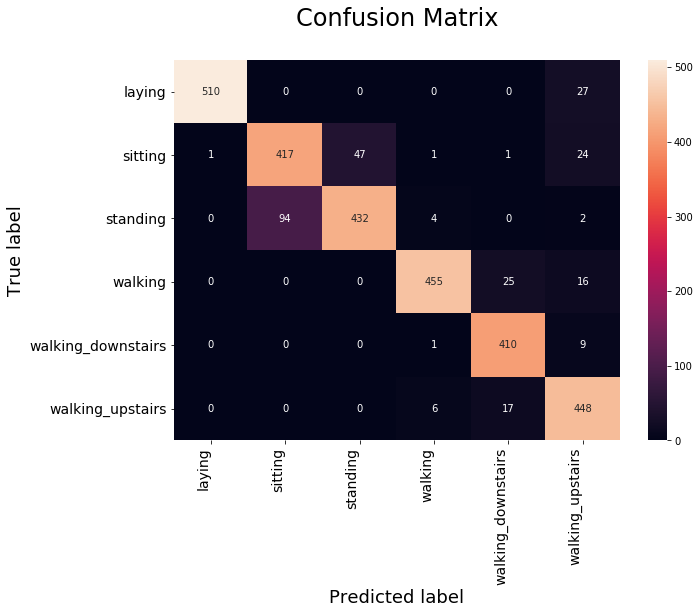

In [31]:
# Final evaluation of the model
scores4 = model4.evaluate(X_test, Y_test, verbose=0)
print("Test Score: %f" % (scores4[0]))
print("Test Accuracy: %f%%" % (scores4[1]*100))

# Confusion Matrix
Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_test, axis=1)])
Y_predictions = pd.Series([ACTIVITIES[y] for y in np.argmax(model4.predict(X_test), axis=1)])

# Code for drawing seaborn heatmaps
class_names = ['laying','sitting','standing','walking','walking_downstairs','walking_upstairs']
df_heatmap = pd.DataFrame(confusion_matrix(Y_true, Y_predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predicted label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()


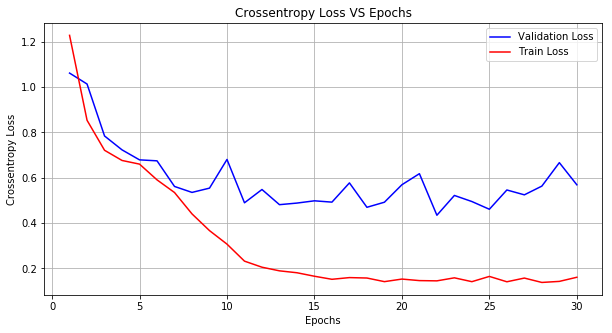

In [44]:
# Test and train accuracy of the model
model_4_test = scores4[1]
model_4_train = max(history4.history['acc'])

# Plotting Train and Test Loss VS no. of epochs
# list of epoch numbers
x = list(range(1,31))

# Validation loss
vy = history4.history['val_loss']
# Training loss
ty = history4.history['loss']

# Calling the function to draw the plot
plt_dynamic(x, vy, ty)

## 5. Model having 2 LSTM layer with 64 LSTM Units and with larger Dropout

In [33]:
# Initiliazing the sequential model
model5 = Sequential()
# Configuring the parameters
model5.add(LSTM(64,return_sequences=True, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model5.add(Dropout(0.7))

# Configuring the parameters
model5.add(LSTM(64))
# Adding a dropout layer
model5.add(Dropout(0.7))
# Adding a dense output layer with sigmoid activation
model5.add(Dense(n_classes, activation='sigmoid'))
print(model5.summary())

# Compiling the model
model5.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

# Training the model
history5 = model5.fit(X_train,Y_train,batch_size=batch_size,validation_data=(X_test, Y_test),epochs=epochs)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 128, 64)           18944     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128, 64)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 390       
Total params: 52,358
Trainable params: 52,358
Non-trainable params: 0
_________________________________________________________________
None
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 113s 15ms/step - loss: 1.2066

Test Score: 0.565438
Test Accuracy: 89.684425%


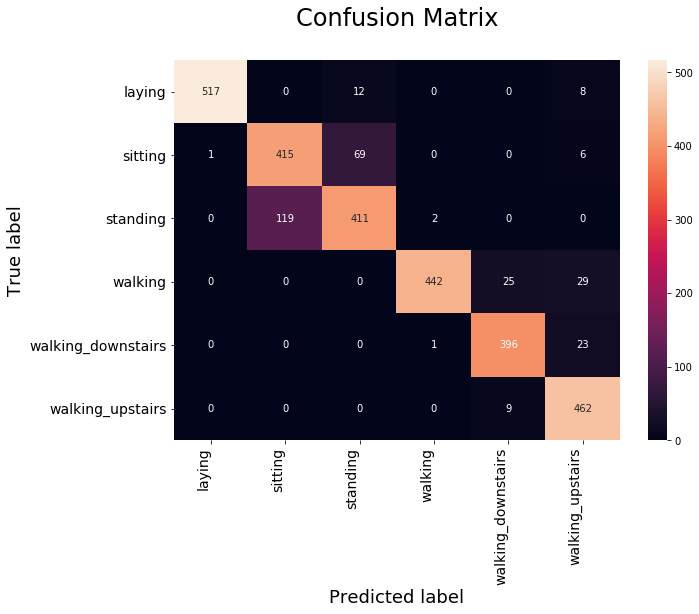

In [34]:
# Final evaluation of the model
scores5 = model5.evaluate(X_test, Y_test, verbose=0)
print("Test Score: %f" % (scores5[0]))
print("Test Accuracy: %f%%" % (scores5[1]*100))

# Confusion Matrix
Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_test, axis=1)])
Y_predictions = pd.Series([ACTIVITIES[y] for y in np.argmax(model5.predict(X_test), axis=1)])

# Code for drawing seaborn heatmaps
class_names = ['laying','sitting','standing','walking','walking_downstairs','walking_upstairs']
df_heatmap = pd.DataFrame(confusion_matrix(Y_true, Y_predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predicted label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

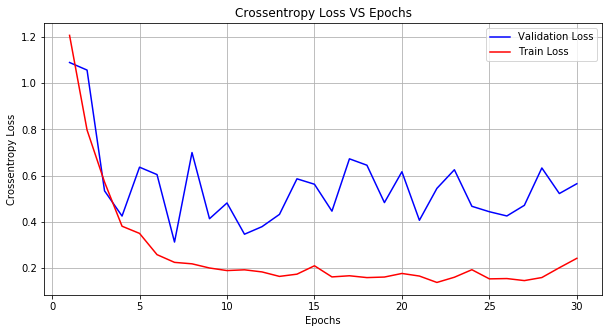

In [45]:
# Test and train accuracy of the model
model_5_test = scores5[1]
model_5_train = max(history5.history['acc'])

# Plotting Train and Test Loss VS no. of epochs
# list of epoch numbers
x = list(range(1,31))

# Validation loss
vy = history5.history['val_loss']
# Training loss
ty = history5.history['loss']

# Calling the function to draw the plot
plt_dynamic(x, vy, ty)

## Conclusion

In [37]:
from prettytable import PrettyTable

print('Performance Table')
x = PrettyTable()
x.field_names =["Models","Train","Test"]

x.add_row(["Model having 1 LSTM layer with 32 LSTM Units",model_1_train,model_1_test])
x.add_row(["Model having 1 LSTM layer with 42 LSTM Units",model_2_train,model_2_test])
x.add_row(["Model having 1 LSTM layer with 64 LSTM Units with larger Dropout",model_3_train,model_3_test])
x.add_row(["Model having 2 LSTM layer with 32 LSTM Units",model_4_train,model_4_test])
x.add_row(["Model having 2 LSTM layer with 64 LSTM Units and with larger Dropout",model_5_train,model_5_test])

print(x)

Performance Table
+----------------------------------------------------------------------+--------------------+--------------------+
|                                Models                                |       Train        |        Test        |
+----------------------------------------------------------------------+--------------------+--------------------+
|             Model having 1 LSTM layer with 32 LSTM Units             | 0.9416485310119695 | 0.8829317950458093 |
|             Model having 1 LSTM layer with 42 LSTM Units             | 0.9513057671381937 | 0.9158466236851035 |
|   Model having 1 LSTM layer with 64 LSTM Units with larger Dropout   | 0.9483133841131665 | 0.9148286392941974 |
|             Model having 2 LSTM layer with 32 LSTM Units             | 0.9530739934711643 | 0.9066847641669494 |
| Model having 2 LSTM layer with 64 LSTM Units and with larger Dropout | 0.9488574537540805 | 0.8968442483881914 |
+-------------------------------------------------------------